In [35]:
#Import and declare TIC

%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from scipy.interpolate import make_interp_spline as spline
import scipy.signal as signal

# plt.style.use('seaborn-v0_8-darkgrid')

TIC = 'TIC 337646214'

In [ ]:
#Download the data
search_results = lk.search_lightcurve(TIC)
used_result = search_results[0]
lc = used_result.download()


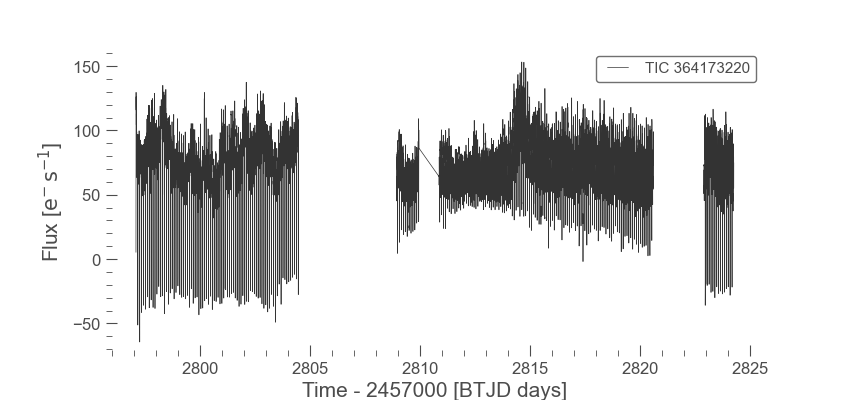

In [3]:
lc.plot()

#Setting up the arrays
time = np.array(lc.time.btjd)
cadence_multiplier = 86400/(np.median(np.diff(time[0:100])) * 86400).round()
time = (time - time[0]) * cadence_multiplier
time = time.round(0)
flux = np.array(lc.flux, dtype=float)
lightcurvepd = pd.DataFrame({'Time':time, 'Flux':flux})

#Filling in missing times with nans
time_interval = 1
min_time = time[0]
max_time = time[-1]
full_time = np.arange(min_time, max_time + time_interval, time_interval)
lightcurvepd.set_index('Time', inplace=True)
lightcurvepd = lightcurvepd.reindex(full_time)

#Filling in the Nans by interpolation
lightcurvepd['Flux'].interpolate(method='linear', inplace=True)

#reset index
lightcurvepd.reset_index(inplace=True)
lightcurvepd.rename(columns={'index':'Time'}, inplace=True)
lightcurvepd['Time'] = (lightcurvepd['Time'] / cadence_multiplier) + lc.time.btjd[0] + 2457000


In [54]:
''' (DONT USE FOR NOW) '''
#Setting up the arrays and jumping over gaps (by filling them with a straight line)

#getting the indices of gap. 'r' = index of right point. 'l' = index of left point.
r = np.searchsorted(time, 1996, 'right')
l = r - 1

#getting the line equation
m = (flux[r] - flux[l]) / (time[r] - time[l])
c = - (m * time[l]) + flux[l]
x = np.linspace(time[l], time[r], 100)[1:-1]
y = m * x + c

#filling the gap with the line
fixed_time = np.concatenate((time[:l], x, time[r:]))
fixed_flux = np.concatenate((flux[:l], y, flux[r:]))



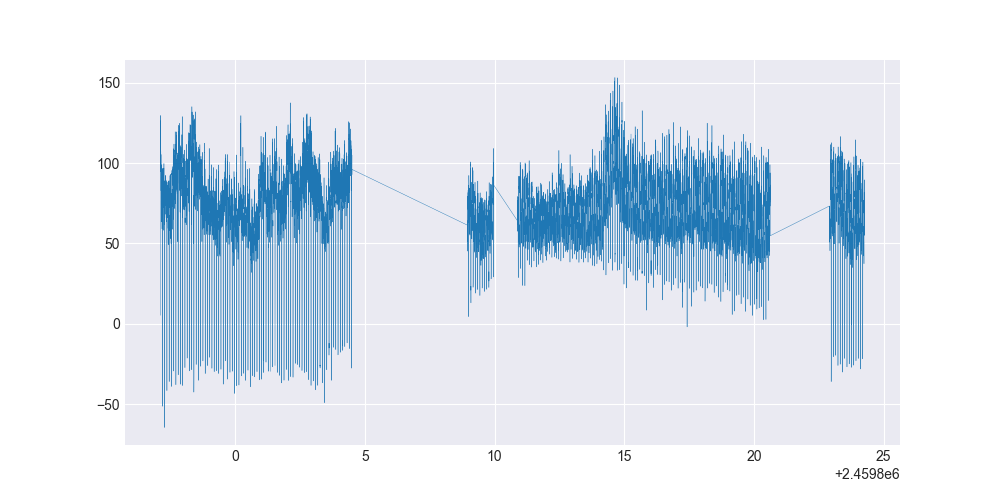

In [4]:
#Making the light curve smoother, with a spline interpolation (IN CASE OF NO GAPS)

time_smooth = np.linspace(lightcurvepd['Time'].min(), lightcurvepd['Time'].max(), 200000)
spl = spline(lightcurvepd['Time'], lightcurvepd['Flux'], k=3)
flux_smooth = spl(time_smooth)

#Plotting the splined lightcurve
plt.figure(figsize=(10, 5))
plt.plot(lightcurvepd['Time'], lightcurvepd['Flux'], lw = 0.3)
# plt.plot(time_smooth, flux_smooth, 'r-', lw=1)

In [ ]:
'''Don't need to use for now'''
#Building the lightcurve again
final_lc = lk.LightCurve(time=time_smooth, flux=flux_smooth)

# f = final_lc.to_periodogram(method='bls').plot(color='red', lw=0.5)
g = lc.to_periodogram(method='ls').plot(view = 'period', color='black', lw=0.5)
final_lc.to_periodogram(method='ls').plot(view = 'period', color='blue', lw=0.5, ax=g)

[2459797.10632591 2459797.10646172 2459797.10659754 ... 2459824.26855429
 2459824.2686901  2459824.26882591]


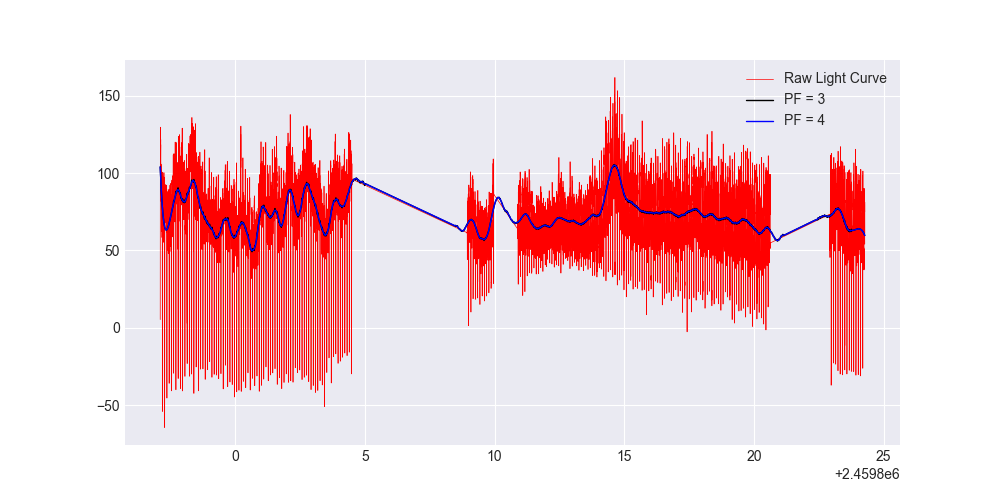

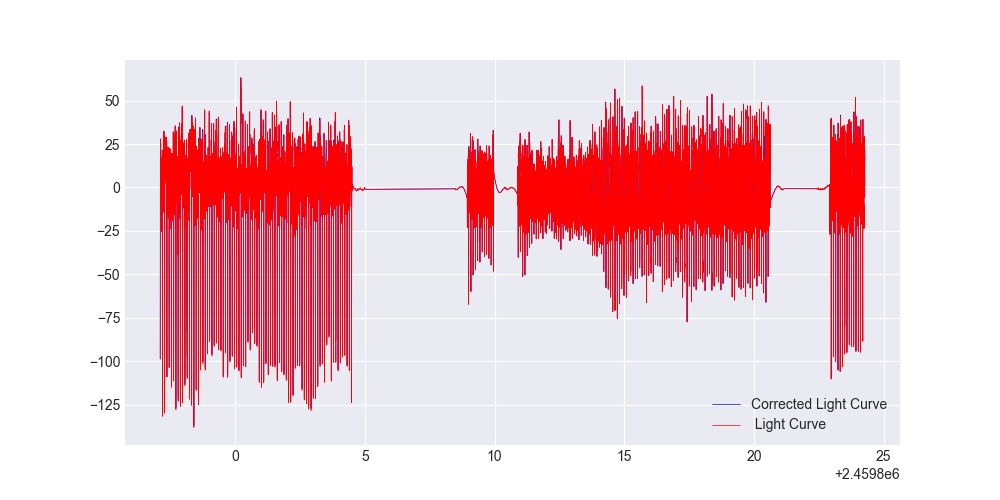

In [6]:
#Applying the savgol filter and plotting!
def apply_savgol_filter(time_smooth, flux_smooth, window_length=2000):
    '''
    applies the savgol filter to 'flux_smooth' and 'time_smooth' with a 'window_length'
    
    returns the corrected lightcurve as lightkurve.LightCurve object and the regression curve itself
    '''
    if window_length == 2000:  #Removing the outburst and other large features
        flx = signal.savgol_filter(flux_smooth, 7500, 4)
        flx2 = signal.savgol_filter(flx, window_length, 4)
        # flx3 = signal.savgol_filter(flux_smooth, 7000, 4)

        #plotting the savgol
        plt.figure(figsize=(10, 5))
        plt.plot(time_smooth, flux_smooth, 'r-', lw=0.5, label='Raw Light Curve')
        plt.plot(time_smooth, flx, 'k-', lw =1, label='PF = 3')
        plt.plot(time_smooth, flx2, 'b-', lw=1, label='PF = 4')
        # plt.plot(time_smooth, flx3, 'g-', lw=1, label='PF = 4, with 7000 window length')
        plt.legend()

        #plotting the processed graph
        plt.figure(figsize=(10, 5))
        plt.plot(time_smooth, flux_smooth - flx2, 'b-', lw=0.5, label='Corrected Light Curve')
        plt.plot(time_smooth, flux_smooth - flx, 'r-', lw=0.5, label=' Light Curve')
        plt.legend()

        #Building the lightcurve again, with the correction
        print(time_smooth)
        return lk.LightCurve(time=time_smooth, flux=flux_smooth - flx2)

    else:  #Finding the gaussians techincally
        flx2 = signal.savgol_filter(flux_smooth, window_length, 4)
        plt.figure(figsize=(10, 5))
        plt.plot(time_smooth, flux_smooth, 'r-', lw=0.5, label='Raw Light Curve')
        # plt.plot(time_smooth, flx, 'k-', lw =1, label='PF = 3')
        plt.plot(time_smooth, flx2, 'k-', lw=1, label='PF = 4')
        # plt.plot(time_smooth, flx3, 'g-', lw=1, label='PF = 4, with 7000 window length')
        plt.legend()

        plt.figure(figsize=(10, 5))
        plt.plot(time_smooth, flux_smooth - flx2, 'b-', lw=0.5, label='Corrected Light Curve')

        #Building the lightcurve again, with the correction
        print(time_smooth)
        return (lk.LightCurve(time = time_smooth, flux=flux_smooth - flx2), lk.LightCurve(time = time_smooth, flux= -flx2))


corrected_lc = apply_savgol_filter(time_smooth, flux_smooth)

[2459797.10632591 2459797.10646172 2459797.10659754 ... 2459824.26855429
 2459824.2686901  2459824.26882591]


<Axes: xlabel='Time [JD]', ylabel='Flux'>

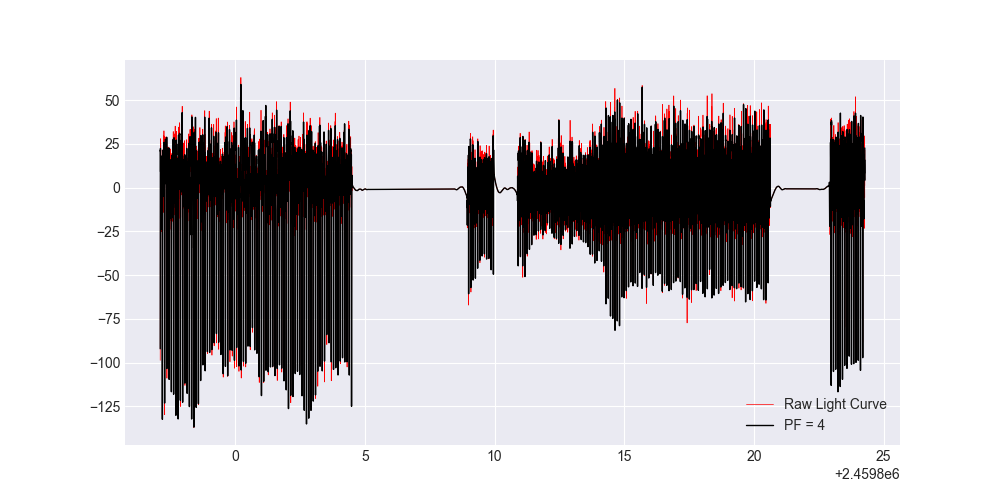

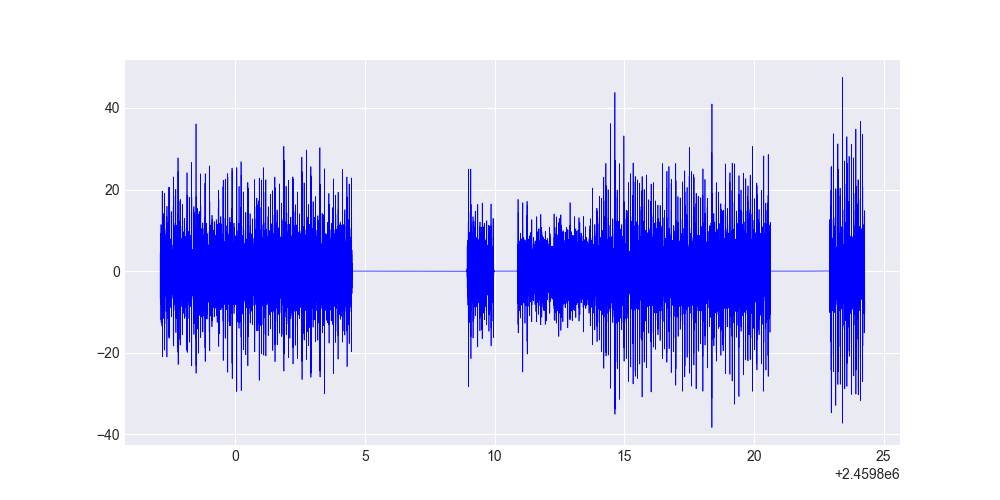

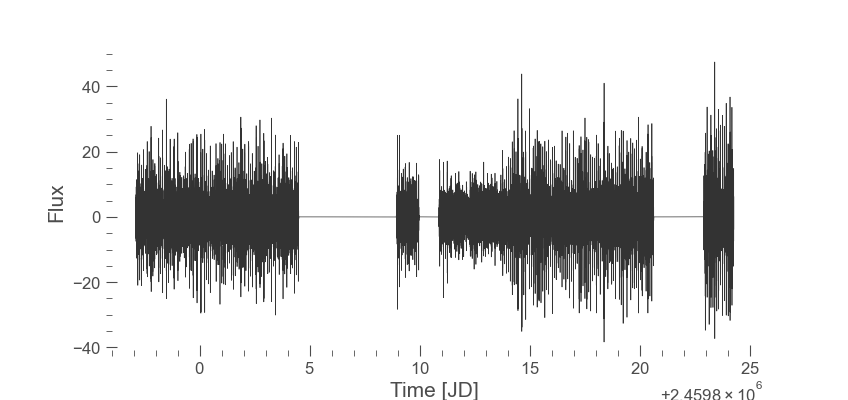

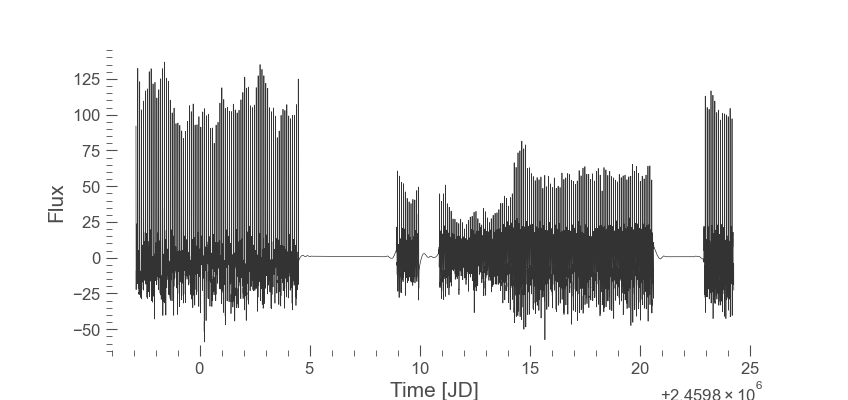

In [7]:
new_ls = apply_savgol_filter(time_smooth, corrected_lc.flux, 100)
new_corrected = new_ls[0]
fitted = new_ls[1]


new_corrected.plot()
fitted.plot()

In [ ]:
'''Don't need to use for now'''
bls = new_corrected.to_periodogram(method='bls')
bls = fitted.to_periodogram(method='bls')

planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power


planet_b_mask = bls.get_transit_mask(period=planet_b_period,
                                     transit_time=planet_b_t0,
                                     duration=planet_b_dur)

masked_lc = fitted[~planet_b_mask]
ax = masked_lc.scatter()
fitted[planet_b_mask].scatter(ax=ax, c='r', label='Masked')

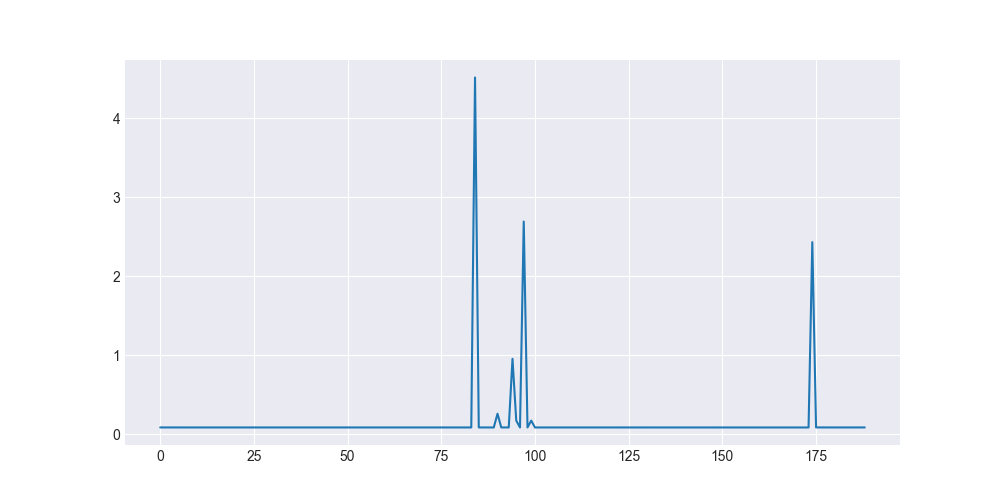

Peak differences: 189
Peak differences (outliers removed): 184


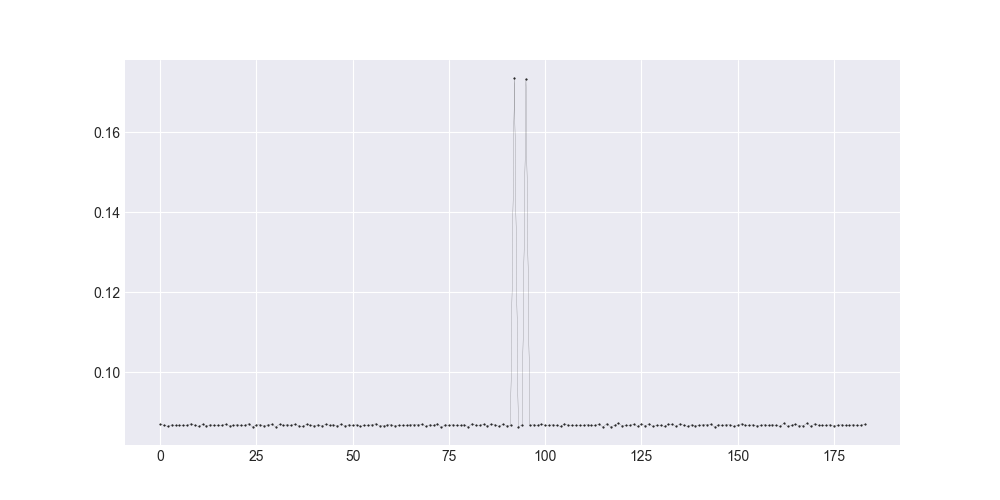

In [34]:
#Function for checking the differences in peaks and also O-C maker

def find_peak_diffs(fitted : lk.LightCurve, threshold, number_of_gaps = 10):
    '''
    Finds the differences (and mean & median) between the peaks of a locally-weighted-regression-ed lightcurve.

    Parameters:
    -----------
    `fitted` : `lightkurve.LightCurve` or `pd.Dataframe` with columns `'time'` and `'flux'` 
        The lightcurve that has been locally weighted regressed.
    `threshold` : `float`
        The threshold for the peak detection.
    `number_of_gaps` : `int`
        (default = 10)
        The aproximate number of gaps, always enter a much higher value than the true number.

    Returns:
    --------
    `mean_diff` : `float`
        The mean difference between the peaks.
    `median_diff` : `float`
        The median difference between the peaks.
    `peak_times` : `numpy.ndarray`
        The times of the peaks.
    '''

    import lightkurve as lk
    import pandas as pd
    from scipy.signal import find_peaks
    import numpy as np
    import matplotlib.pyplot as plt

    # Get the flux and time values
    if isinstance(fitted, lk.LightCurve):
        fl = np.array(fitted.flux)
        tm = np.array(fitted.time.btjd)
    if isinstance(fitted, pd.DataFrame):
        fl = np.array(fitted['flux'])
        tm = np.array(fitted['time'])

    # Find peaks in fl above threshold
    peaks, _ = find_peaks(fl, height=threshold)

    # Get the associated time values for the peaks
    peak_times = tm[peaks]

    # Print the peak times
    plt.figure(figsize=(10, 5))
    plt.plot(np.diff(peak_times))
    plt.show()

    mean_diff = np.sort(np.diff(peak_times))[:-10].mean()
    median_diff = np.median(np.sort(np.diff(peak_times))[:-10])

    return mean_diff, median_diff, np.diff(peak_times)

def reject_outliers(data, m=1):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def make_O_C(fitted, peak_differences):
    '''
    Makes the O-C diagram for a given lightcurve, period, t0 and duration.
    '''

    mean_diff, median_diff, peak_differences = find_peak_diffs(fitted, 40)
    p = reject_outliers(peak_differences, 0.15)

    print(f'Peak differences: {len(peak_differences)}')
    print(f'Peak differences (outliers removed): {len(p)}')

    plt.figure(figsize=(10, 5))
    plt.plot(p, linestyle=None, marker = 'o', lw = 0.1, markersize = 0.5, color = 'black')
    plt.show()
    
make_O_C(fitted, 40)

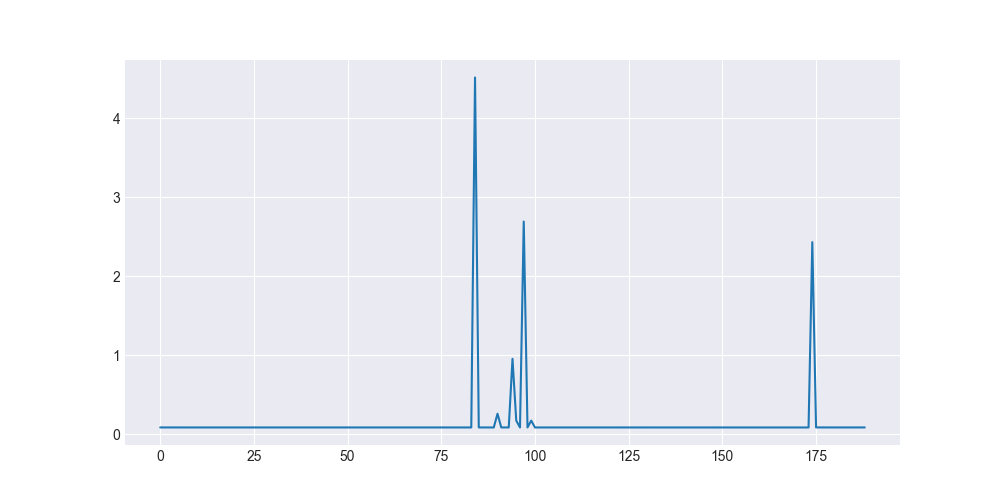

Peak differences: 189
Peak differences (outliers removed): 185


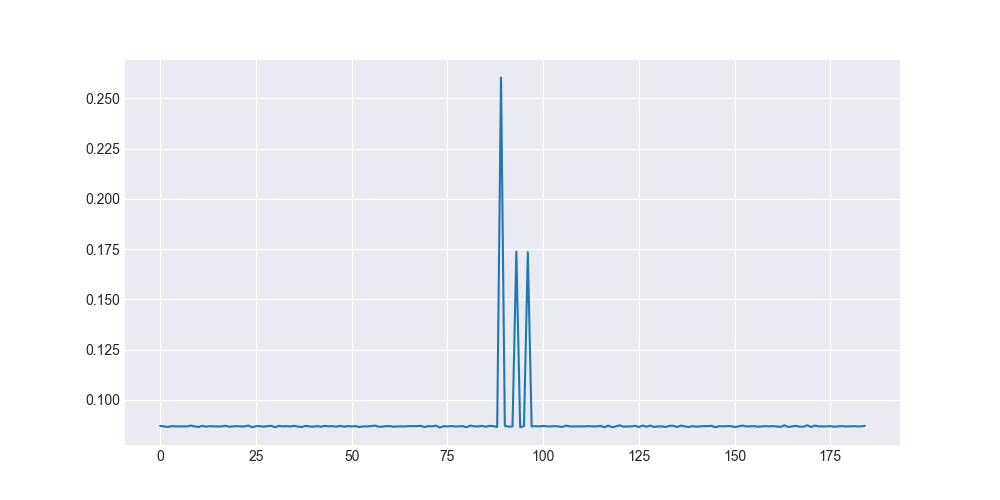

In [ ]:
find_peak_diffs(fitted, 40, 10

In [1]:
import astropy.units as u

# new_corrected.fold(period = 0.0867846217006445, epoch_time = 10).bin(time_bin_size=0.05 * u.minute).scatter()
g = corrected_lc.fold(period = 0.08681421200146472).bin(time_bin_size=0.5 * u.minute).scatter()
corrected_lc.fold(period = 0.0867846217006445).bin(time_bin_size=0.5 * u.minute).scatter(ax=g, color='green')

NameError: name 'corrected_lc' is not defined

In [282]:
print(0.08681421200146472*86400, 0.0867846217006445*86400)

7500.747916926552 7498.191314935684


/opt/homebrew/lib/python3.11/site-packages/lightkurve/lightcurve.py:1131: LightkurveWarning: The light curve appears to be zero-centered (median=-7.55e-01 +/- 1.99e+01); `normalize()` will divide the light curve by a value close to zero, which is probably not what you want.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/lightkurve/lightcurve.py:1142: LightkurveWarning: The light curve has a negative median flux (-7.55e-01); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  warnings.warn(


<class 'lightkurve.lightcurve.LightCurve'>


KeyError: 'centroid_col'

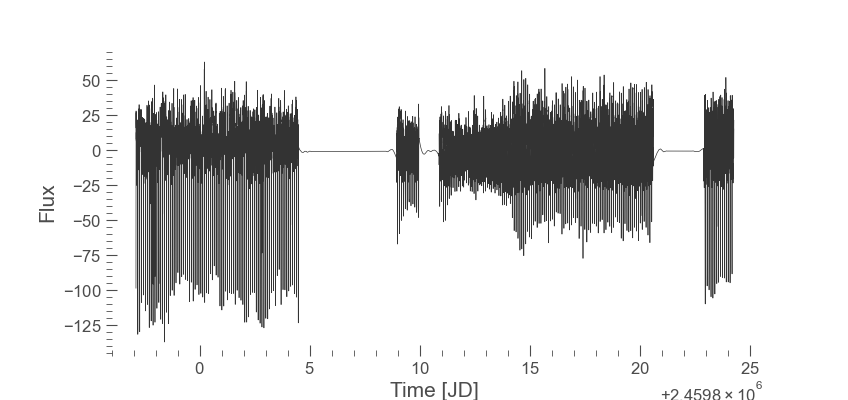

In [292]:
corrected_lc.plot()
clc1 = corrected_lc.normalize().remove_nans().remove_outliers()
print(type(clc1))
clc2 = lk.correctors.SFFCorrector(clc1).correct(windows=10).remove_outliers().fill_gaps()
clc2.plot()